In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import re

class ProjectDataAnalysis:
    def __init__(self, file_path, columns_to_keep):
        self.file_path = file_path
        self.columns_to_keep = columns_to_keep
        self.data = self.load_dataset()
        self.data['individual_labels'] = self.data['main_research_priority_area_number_new'].apply(lambda x: self.clean_labels(x.split(',')))
        self.label_counts = Counter([label for sublist in self.data['individual_labels'] for label in sublist])
        self.combination_counts = Counter([combo for sublist in self.data['individual_labels'] for combo in combinations(sorted(sublist), 2)])

    def load_dataset(self):
        """
        Load the dataset and keep specified columns.
        """
        data = pd.read_csv(self.file_path)
        data = data[self.columns_to_keep]
        data['grant_title_eng'] = data['grant_title_eng'].fillna('')
        data['abstract'] = data['abstract'].fillna('')
        data['main_research_priority_area_number_new'] = data['main_research_priority_area_number_new'].fillna('')
        return data

    def clean_labels(self, labels):
        """
        Clean the labels by removing any trailing non-numeric characters.
        Only keep labels that are between 1 and 12 inclusive.
        """
        cleaned_labels = []
        for label in labels:
            cleaned_label = re.sub(r'\D', '', label).strip()
            if cleaned_label.isdigit():
                cleaned_label = int(cleaned_label)
                if 1 <= cleaned_label <= 12:
                    cleaned_labels.append(str(cleaned_label))
        return cleaned_labels

    def analyse_project_lengths(self):
        """
        Analyse the length of project titles and abstracts.
        """
        self.data['title_length_chars'] = self.data['grant_title_eng'].apply(len)
        self.data['abstract_length_chars'] = self.data['abstract'].apply(len)

        self.data['title_length_words'] = self.data['grant_title_eng'].apply(lambda x: len(x.split()))
        self.data['abstract_length_words'] = self.data['abstract'].apply(lambda x: len(x.split()))

        title_length_chars_stats = {
            'average_length': self.data['title_length_chars'].mean(),
            'max_length': self.data['title_length_chars'].max()
        }

        abstract_length_chars_stats = {
            'average_length': self.data['abstract_length_chars'].mean(),
            'max_length': self.data['abstract_length_chars'].max()
        }

        title_length_words_stats = {
            'average_length': self.data['title_length_words'].mean(),
            'max_length': self.data['title_length_words'].max()
        }

        abstract_length_words_stats = {
            'average_length': self.data['abstract_length_words'].mean(),
            'max_length': self.data['abstract_length_words'].max()
        }

        return {
            'title_length_chars_stats': title_length_chars_stats,
            'abstract_length_chars_stats': abstract_length_chars_stats,
            'title_length_words_stats': title_length_words_stats,
            'abstract_length_words_stats': abstract_length_words_stats
        }

    def analyse_individual_label_distributions(self):
        """
        Analyse the individual label distributions.
        """
        # Count individual labels
        all_labels = [label for sublist in self.data['individual_labels'] for label in sublist]
        individual_label_counts = Counter(all_labels)

        return individual_label_counts

    def analyse_label_correlations(self):
        """
        Analyse the correlations of categories appearing together.
        """
        label_combinations = Counter()
        for labels in self.data['individual_labels']:
            for combo in combinations(sorted(labels), 2):
                label_combinations[combo] += 1

        return label_combinations

    def get_top_combinations(self, top_n=5):
        return [combo for combo, count in self.combination_counts.most_common(top_n)]

    def find_top_conditional_probabilities(self, top_combinations, min_occurrences=5):
        conditional_probs = {}
        
        for combo in top_combinations:
            third_label_counter = Counter()
            combo_occurrences = 0
            for labels in self.data['individual_labels']:
                if all(label in labels for label in combo):
                    combo_occurrences += 1
                    for label in labels:
                        if label not in combo:
                            third_label_counter[label] += 1
            
            if combo_occurrences >= min_occurrences:
                top_label, top_count = third_label_counter.most_common(1)[0]
                conditional_probs[combo] = (top_label, top_count / combo_occurrences)
        
        return conditional_probs

    def print_conditional_probabilities(self, conditional_probs):
        for combo, (label, prob) in conditional_probs.items():
            print(f"Top conditional probability for combination {combo}:")
            print(f"  P({label} | {combo}) = {prob:.2f}")

    def plot_label_distribution(self, label_counts, title, xlabel):
        """
        Plot the label distribution.
        """
        labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))  # Sort labels by frequency
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(labels, counts, color='skyblue')

        ax.set_title(title, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adding count labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

    def plot_combined_label_distribution(self, label_correlations, title):
        """
        Plot the combined label distribution for the top 12 labels.
        """
        # Get top 12 most frequent label combinations
        top_combined_labels = dict(Counter(label_correlations).most_common(12))

        labels = [f"{k[0]},{k[1]}" for k in top_combined_labels.keys()]
        counts = list(top_combined_labels.values())

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(labels, counts, color='skyblue')

        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Research Categories Assigned', fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adding count labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

    def plot_label_correlations_heatmap(self, label_correlations):
        """
        Plot a heatmap of label correlations.
        """
        labels = sorted(set([label for combo in label_correlations.keys() for label in combo]))
        correlation_matrix = pd.DataFrame(0, index=labels, columns=labels)

        for (label1, label2), count in label_correlations.items():
            correlation_matrix.loc[label1, label2] = count
            correlation_matrix.loc[label2, label1] = count

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='g')
        plt.title('Correlation Heatmap of Research Categories in the Training Set')
        plt.xlabel('Research Category')
        plt.ylabel('Research Category')
        plt.show()

# Assuming 'train_data.csv' is in the current directory and has the correct columns
columns_to_keep = ['pactid', 'grant_title_eng', 'abstract', 'main_research_priority_area_number_new']
analysis = ProjectDataAnalysis('train_data.csv', columns_to_keep)

In [31]:
# Print results
print("Project Length Statistics:")
print(length_stats)

Project Length Statistics:
{'title_length_chars_stats': {'average_length': 101.22735897878214, 'max_length': 850}, 'abstract_length_chars_stats': {'average_length': 1799.0596860445057, 'max_length': 12206}, 'title_length_words_stats': {'average_length': 13.663791616353286, 'max_length': 133}, 'abstract_length_words_stats': {'average_length': 259.44971537001896, 'max_length': 1777}}


In [32]:
# Run analysis
length_stats = analysis.analyse_project_lengths()
print('length_stats = ',length_stats)

individual_label_counts = analysis.analyse_individual_label_distributions()
label_correlations = analysis.analyse_label_correlations()

length_stats =  {'title_length_chars_stats': {'average_length': 101.22735897878214, 'max_length': 850}, 'abstract_length_chars_stats': {'average_length': 1799.0596860445057, 'max_length': 12206}, 'title_length_words_stats': {'average_length': 13.663791616353286, 'max_length': 133}, 'abstract_length_words_stats': {'average_length': 259.44971537001896, 'max_length': 1777}}


In [33]:
print("\nLabel Correlations:")
print(label_correlations)


Label Correlations:
Counter({('1', '4'): 470, ('10', '9'): 224, ('3', '4'): 221, ('1', '6'): 209, ('1', '3'): 207, ('10', '11'): 159, ('1', '7'): 158, ('4', '6'): 156, ('1', '2'): 92, ('3', '9'): 90, ('11', '9'): 79, ('10', '4'): 71, ('10', '3'): 62, ('2', '3'): 59, ('5', '9'): 58, ('6', '7'): 56, ('3', '5'): 55, ('4', '9'): 54, ('11', '4'): 47, ('4', '7'): 38, ('8', '9'): 31, ('7', '9'): 27, ('10', '5'): 27, ('12', '9'): 27, ('10', '8'): 26, ('1', '5'): 25, ('1', '9'): 23, ('4', '5'): 22, ('11', '12'): 22, ('11', '8'): 20, ('1', '11'): 18, ('11', '7'): 17, ('10', '12'): 16, ('3', '7'): 16, ('11', '3'): 15, ('2', '4'): 14, ('4', '8'): 13, ('3', '8'): 10, ('11', '6'): 9, ('3', '6'): 9, ('2', '9'): 9, ('1', '10'): 8, ('12', '4'): 8, ('11', '5'): 7, ('6', '9'): 7, ('2', '5'): 5, ('2', '7'): 5, ('6', '8'): 5, ('7', '8'): 5, ('12', '7'): 5, ('10', '6'): 5, ('12', '8'): 4, ('12', '3'): 4, ('1', '8'): 4, ('11', '2'): 4, ('12', '6'): 3, ('10', '7'): 3, ('5', '8'): 3, ('1', '12'): 2, ('12', '5

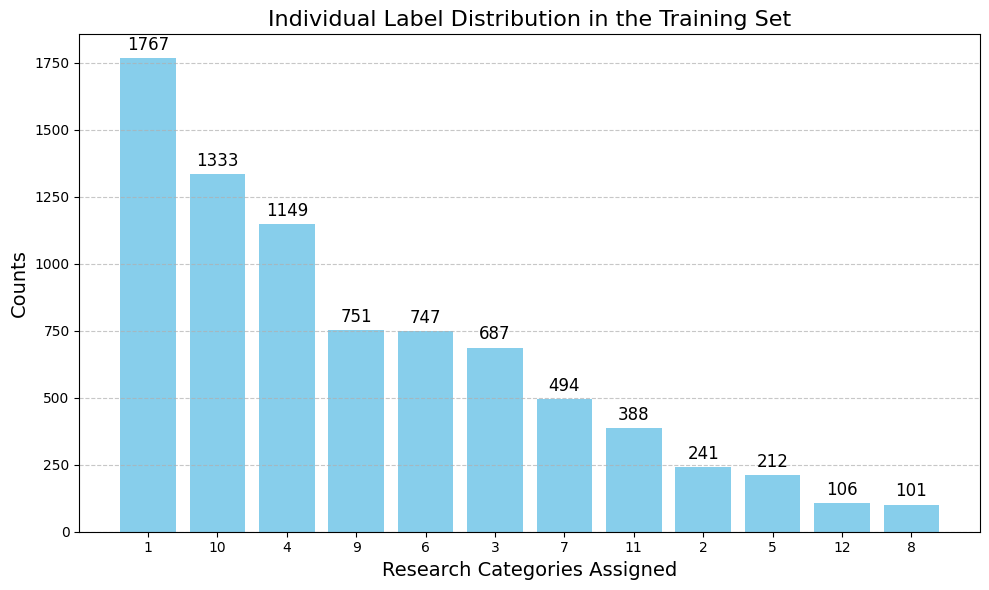

In [34]:
# Plot distributions
analysis.plot_label_distribution(individual_label_counts, 'Individual Label Distribution in the Training Set', 'Research Categories Assigned')

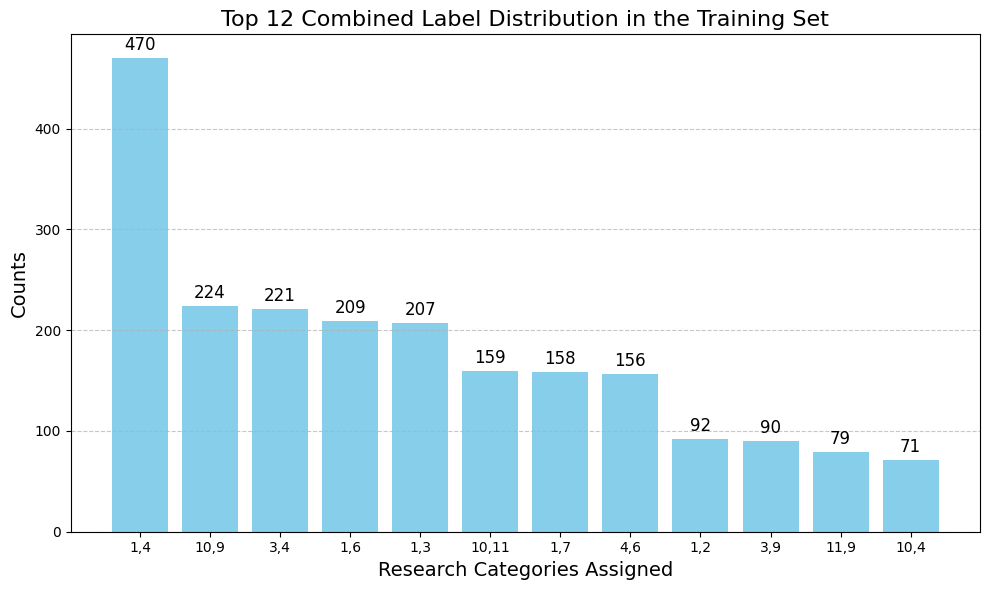

In [35]:
analysis.plot_combined_label_distribution(label_correlations, 'Top 12 Combined Label Distribution in the Training Set')

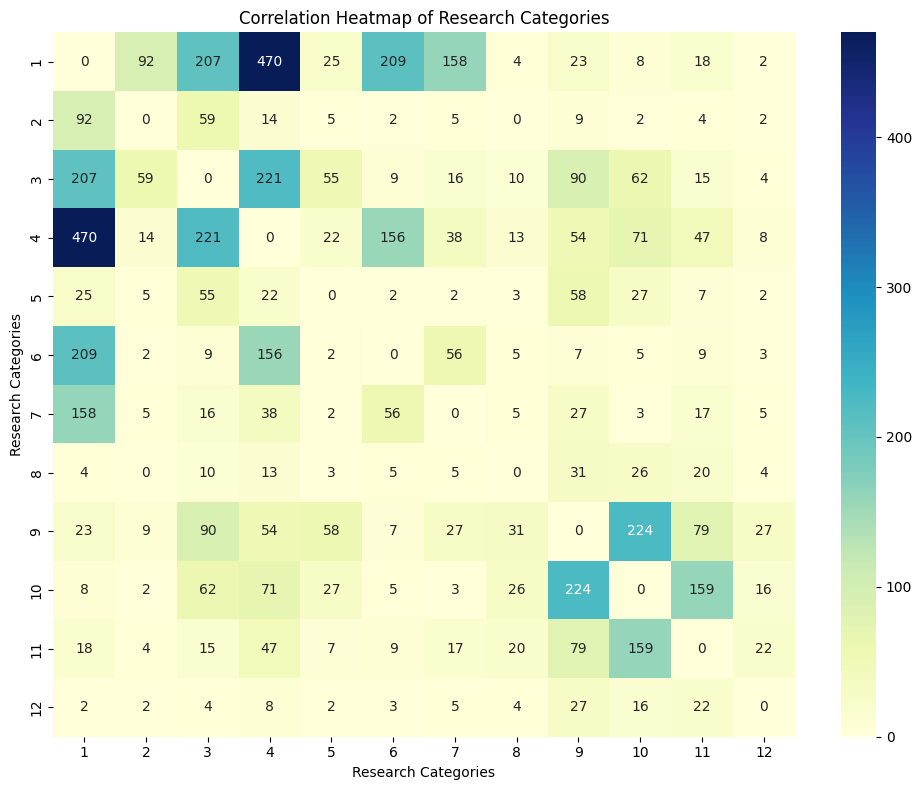

In [36]:
# Generate Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Correlation data
correlation_data = label_correlations

# Create a matrix for the heatmap
labels = list(set([item for sublist in correlation_data.keys() for item in sublist]))
labels.sort(key=int)

# Initialize the matrix with zeros
heatmap_matrix = np.zeros((len(labels), len(labels)))

# Populate the matrix with the counts
for (cat1, cat2), count in correlation_data.items():
    idx1 = labels.index(cat1)
    idx2 = labels.index(cat2)
    heatmap_matrix[idx1, idx2] = count
    heatmap_matrix[idx2, idx1] = count  # Ensure the matrix is symmetric

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, xticklabels=labels, yticklabels=labels, cmap="YlGnBu", annot=True, fmt="g")
plt.title('Correlation Heatmap of Research Categories')
plt.xlabel('Research Categories')
plt.ylabel('Research Categories')
plt.tight_layout()

# Save the figure
plt.savefig('label_correlations_heatmap.png')

# Show the plot
plt.show()

In [37]:
# Top 5 combinations
top_combinations = analysis.get_top_combinations(top_n=5)
conditional_probs = analysis.find_top_conditional_probabilities(top_combinations, min_occurrences=5)

# Print the top conditional probabilities
analysis.print_conditional_probabilities(conditional_probs)

Top conditional probability for combination ('1', '4'):
  P(3 | ('1', '4')) = 0.17
Top conditional probability for combination ('10', '9'):
  P(11 | ('10', '9')) = 0.12
Top conditional probability for combination ('3', '4'):
  P(1 | ('3', '4')) = 0.35
Top conditional probability for combination ('1', '6'):
  P(4 | ('1', '6')) = 0.27
Top conditional probability for combination ('1', '3'):
  P(4 | ('1', '3')) = 0.38


Project Length Statistics:
{'title_length_chars_stats': {'average_length': 101.22735897878214, 'max_length': 850}, 'abstract_length_chars_stats': {'average_length': 1799.0596860445057, 'max_length': 12206}, 'title_length_words_stats': {'average_length': 13.663791616353286, 'max_length': 133}, 'abstract_length_words_stats': {'average_length': 259.44971537001896, 'max_length': 1777}}
length_stats =  {'title_length_chars_stats': {'average_length': 102.23379310344828, 'max_length': 3363}, 'abstract_length_chars_stats': {'average_length': 1796.5958620689655, 'max_length': 11054}, 'title_length_words_stats': {'average_length': 13.810344827586206, 'max_length': 531}, 'abstract_length_words_stats': {'average_length': 258.4772413793103, 'max_length': 1507}}


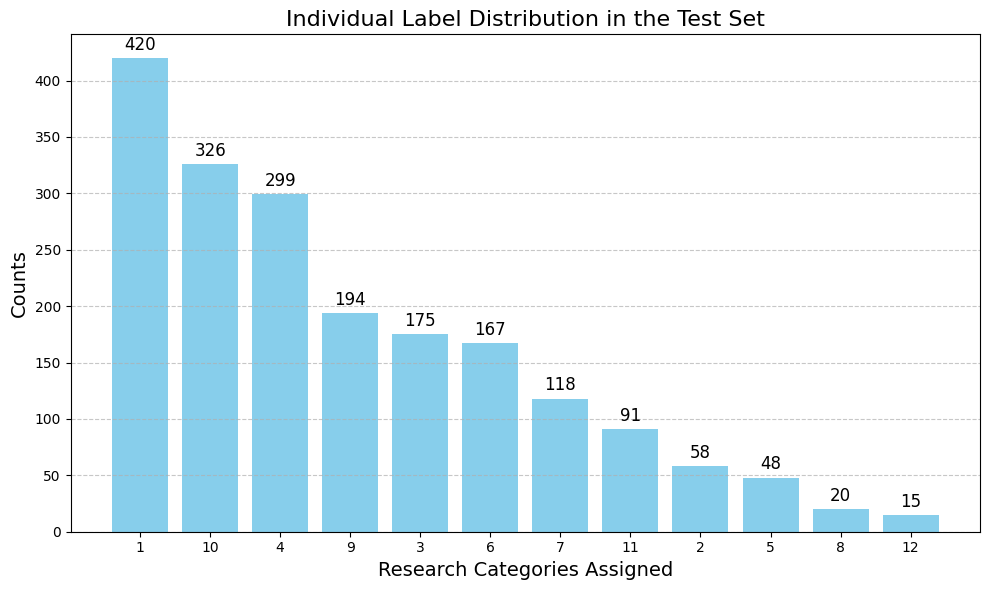

In [40]:
# For test set
analysis = ProjectDataAnalysis('test_data.csv', columns_to_keep)

# Print results
print("Project Length Statistics:")
print(length_stats)

# Run analysis
length_stats = analysis.analyse_project_lengths()
print('length_stats = ',length_stats)

individual_label_counts = analysis.analyse_individual_label_distributions()
label_correlations = analysis.analyse_label_correlations()


# Plot distributions
analysis.plot_label_distribution(individual_label_counts, 'Individual Label Distribution in the Test Set', 'Research Categories Assigned')

In [41]:
individual_label_counts

Counter({'4': 299,
         '1': 420,
         '10': 326,
         '6': 167,
         '3': 175,
         '8': 20,
         '9': 194,
         '7': 118,
         '11': 91,
         '2': 58,
         '5': 48,
         '12': 15})